In [ ]:
!pip install requirements.txt

In [26]:
%load_ext autoreload
%autoreload 2

from flask import Flask
from flask.helpers import get_root_path

from jupyter_dash import JupyterDash
from dash_app.layout import layout
from dash_app.callbacks import register_callbacks

app = JupyterDash(__name__, #server=server,
                  url_base_pathname='/',
                  assets_folder='dash_app/assets/')

app.title = 'Gait Analyzer'
app.layout = layout
register_callbacks(app)

# Run app and display result inline in the notebook
app.run_server(mode='inline', debug=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from plotly.subplots import make_subplots
fig = make_subplots(2, 1, shared_xaxes=True)
for i, n in enumerate(['r_knee_flex', 'l_knee_flex']):
    fig.add_trace(go.Scatter(y=angles[n], name=n), i+1, 1)
fig.update_yaxes(matches='y')
fig.update_layout(dragmode= 'pan', xaxis=dict(range=[0,300]), yaxis=dict(range=[120,190], fixedrange=True))
fig.add_shape(
    dict(type="line", x0=20, x1=20, y0=120, y1=200, line_color="green"), row="all", col=1
)
fig.show()
#fig.update_shapes(dict(x0=30, x1=30))

NameError: name 'go' is not defined

In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from data.gait_cycle_detector import GaitCycleDetector
from data.video import Video
from model.mediapipe_estimator import MediaPipe_Estimator2D
from model.videopose3d import VideoPose3D
from data.skeleton_helper import MediaPipeSkeleton, CocoSkeleton
from data.angle_helper import calc_common_angles

estimator_2d = MediaPipe_Estimator2D(out_format='coco')
estimator_3d = VideoPose3D()
video = Video('/Users/leo/Desktop/Gait/S2/rhcteau.avi') #'dash_app/assets/demo.mp4')
keypoints, meta = estimator_2d.estimate(video)
pose_3d = estimator_3d.estimate(keypoints, meta)['video']
angles = calc_common_angles(pose_3d, clinical=True)

pose_2d = keypoints['video']['custom'][0]

gcd = GaitCycleDetector('coco')
peaks = gcd.simple_detection(pose_2d)

joint_idx = CocoSkeleton().keypoint2index

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
fps = meta['video_metadata']['video']['fps']
new_frames = int(50/fps * len(pose_2d))
t = np.linspace(0, 1, len(pose_2d))
new_t = np.linspace(0, 1, new_frames)

interp_kps = np.zeros([new_frames, *pose_2d.shape[1:]])
for i in range(pose_2d.shape[1]):
    for j in range(pose_2d.shape[2]):
        interp_kps[:, i, j] = np.interp(new_t, t, pose_2d[:,i,j])
#interp_kps

array([[[267.50665665,  89.83338833],
        [273.4088707 ,  80.66569805],
        [271.83868408,  81.21605873],
        ...,
        [281.01711273, 328.83421898],
        [329.65454102, 408.3584404 ],
        [294.56813812, 425.13021469]],

       [[268.39369398,  89.83398017],
        [273.63661997,  80.63580553],
        [272.43470464,  81.20100096],
        ...,
        [281.77091319, 326.03754848],
        [319.54901047, 409.34359839],
        [300.53860236, 416.86732147]],

       [[269.15898204,  89.84045553],
        [273.83854203,  80.61379996],
        [272.97511138,  81.18845249],
        ...,
        [284.76435907, 324.47299227],
        [310.41975014, 410.86607225],
        [305.75503126, 411.92943033]],

       ...,

       [[265.18284529,  85.49080501],
        [270.84070198,  77.28713022],
        [271.37602165,  77.32581429],
        ...,
        [260.60425296, 330.19381832],
        [383.23250011, 422.13716961],
        [246.13829605, 422.63946645]],

       [[265.20

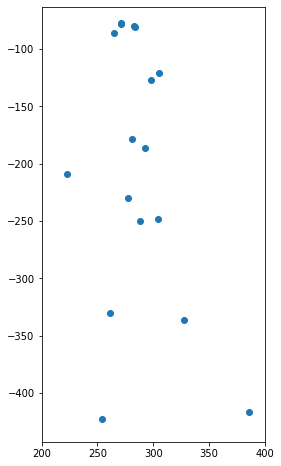

In [47]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animation function.  This is called sequentially
def animate(i):
    t = pose_2d[i]
    skel.set_offsets(t * [1, -1])
    return skel

fig, ax = plt.subplots(figsize=(4,8))
ax.set_xlim([200, 400])
#t = pose_2d[0]
skel = plt.scatter(pose_2d[0, :, 0], -pose_2d[0, :, 1])
anim = FuncAnimation(fig, animate, frames=len(pose_2d), interval=50)
#for i in range(len(t)):
#    plt.text(t[i, 0], -t[i, 1], str(i), color="red", fontsize=12)

HTML(anim.to_jshtml())

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animation function.  This is called sequentially
def animate(i):
    t = pose_3d[i,:,::2]
    skel.set_offsets(t)
    return skel

fig, ax = plt.subplots(figsize=(4,8))
ax.set_xlim([-0.1, 0.2])
#t = pose_2d[0]
skel = plt.scatter(pose_3d[0, :, 0], pose_3d[0, :, 2])
anim = FuncAnimation(fig, animate, frames=len(pose_2d), interval=50)
#for i in range(len(t)):
#    plt.text(t[i, 0], -t[i, 1], str(i), color="red", fontsize=12)

HTML(anim.to_jshtml())

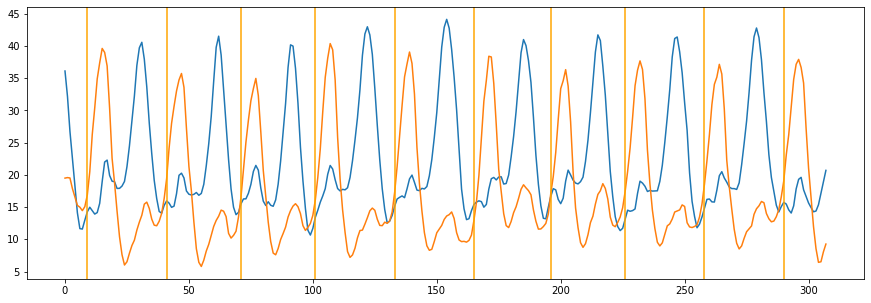

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(angles['LeftKnee'])
plt.plot(angles['RightKnee'])
for mm in peaks.tolist():
    plt.axvline(x=mm, color="orange")
plt.show()